## PART 1: Predict customers' sentiments for IMDB dataset by building and tuning a sequential NLP.

In [ ]:
#Import required libraries
from google.colab import drive
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,BatchNormalization,Dropout,Bidirectional,RNN
from tensorflow.keras.optimizers import RMSprop,Adam, SGD
from tensorflow.keras.regularizers import L2
from keras.callbacks import ModelCheckpoint


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Import and analyse the data set.Take 10000 most frequent words

In [ ]:
(trainX,trainY),(testX,testY)=keras.datasets.imdb.load_data(seed=1, num_words=10000)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
print("Shape of initial train dataset :",(trainX.shape,trainY.shape))
print("Shape of initial test dataset :",(testX.shape,testY.shape))

Shape of initial train dataset : ((25000,), (25000,))
Shape of initial test dataset : ((25000,), (25000,))


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


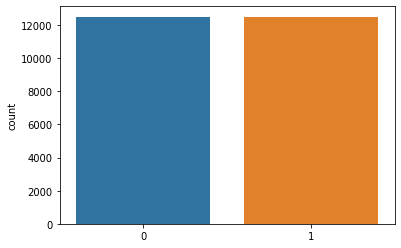

In [ ]:
#Countplot for visualsing the distribution of positive/negative labels
sns.countplot(trainY)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


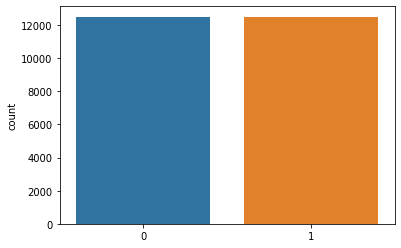

In [ ]:
sns.countplot(testY)

##### From the countplots above, we can see that the sentiments are fairly balanced between 2 classes.

### 2. Perform relevant sequence adding on the data

In [ ]:
maxlen=256

In [ ]:
#Pre-padding the word sequences upto 256 length
trainX_seq = keras.preprocessing.sequence.pad_sequences(trainX, maxlen=maxlen)
testX_seq = keras.preprocessing.sequence.pad_sequences(testX, maxlen=maxlen)

### 3. Perform following data analysis.
*  Print shape of features and labels
*  Print value of any one feature and it's label



In [ ]:
#Print shape of features and labels
print("Shape of training set :" ,(trainX_seq.shape, trainY.shape))
print("Shape of testing set :" ,(testX_seq.shape, testY.shape))

Shape of training set : ((25000, 256), (25000,))
Shape of testing set : ((25000, 256), (25000,))


In [ ]:
#Print value of any one feature and it's label
print("Review  Encoding: \n",trainX_seq[10])
print("Label :",trainY[10])

Review  Encoding: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    1   13  219   14   11 7190   11   51  215   28   77   94
  204  521   13 1227 4985   83    4    2    7    4  750   12   16   15
  163   13  774  110   12  237   21   62  119    8  121   81   25   79
    6 1039 1814  660  233   44   12  112 1967   42 3701   26   18   61
  278   43    6  762    7    2  257 6056    9  345    2  

### 4. Decode the feature value to get original sentence

In [ ]:
#Get word associated with the word index in the dataset
words = keras.datasets.imdb.get_word_index()

In [ ]:
print("Words and their indices :\n",list(words.items())[:10])

Words and their indices :
 [('fawn', 34701), ('tsukino', 52006), ('nunnery', 52007), ('sonja', 16816), ('vani', 63951), ('woods', 1408), ('spiders', 16115), ('hanging', 2345), ('woody', 2289), ('trawling', 52008)]


In [ ]:
#For each review in train and test set, parse each encoded index and map it with the original word
trainX_decoded=[]
testX_decoded=[]
inverted_word_index = dict((key, word) for (word, key) in words.items())
#Decode and store the sequences in a list
for j in range(len(trainX)):
  trainX_decoded.append( " ".join(inverted_word_index[key] for key in trainX[j]))
for j in range(len(testX)):
  testX_decoded.append( " ".join(inverted_word_index[key] for key in testX[j]))

In [ ]:
#Inverted dictionary containing words and their indices
list(inverted_word_index.items())[:10]

[(34701, 'fawn'),
 (52006, 'tsukino'),
 (52007, 'nunnery'),
 (16816, 'sonja'),
 (63951, 'vani'),
 (1408, 'woods'),
 (16115, 'spiders'),
 (2345, 'hanging'),
 (2289, 'woody'),
 (52008, 'trawling')]

In [ ]:
#print original sentence from train feature set
trainX_decoded[10]

"the was least as this relevance this when isn't one will make i've actress was steve instinct first of and br of dull that with for makes was fantastic life that he's not story did in know people have also is doctor horse ones last has that never prove it's intrigued he but only sense out is herself br and having crossing it given and and it's and started having by more it his is buy by forces of today paul but heads really weirdness flawed mess shred through through bin film and sally and story one means that me all of alexander ancient what have saw in as you film so joe second to is and and humor guys and that times first man time where odd"

In [ ]:
#print original sentence from test feature set
testX_decoded[10]

"the more he is again sent in and characters to this parents brady and for was story why could any her him of how it drops to gosh of and br really it of being br and all thing died all thing could think videos an all there he be directed incidents to level and to film while all and of you hospital recently in own want dvd bad kids or as naked being i'm be studios of must to of fascinating it wilder i'm of br dave to that art flawless much i i doesn't of on have one in at featuring br of problem goes limited guys at feared in seems this of characters of goes parts at and movies get more parts at plot seems in long man directed tv or of watched eight it's without hospital horror in kids in few of because too film be characters all properly character's lacks they be night music without this of meant in of able br of goes which better goes to music out has point back this of and in normal man ten be characters he has everywhere leads to screams enjoyed thunder film somewhat to and without

### 5. Design, train, tune and test a sequential model.

In [ ]:
#Define the vocabulary size for creating embedding layer.
vocab_size = 10000

In [ ]:
#Define and train the model
def sequentialModel():

  model=Sequential()
  model.add(Embedding(vocab_size,500,input_length=maxlen))
  model.add(LSTM(128))
  model.add(Dense(256, activation='relu',kernel_regularizer=L2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(128, activation='relu',kernel_regularizer=L2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(50, activation='relu',kernel_regularizer=L2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
  checkpoint1 = ModelCheckpoint("/content/drive/MyDrive/Great Learning/NLP/Assignment 11/best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True)
  model.fit(trainX_seq, trainY, batch_size=32, epochs=10,validation_split=0.2,callbacks=[checkpoint1])
  return model

In [ ]:
#model = keras.models.load_model('/content/drive/MyDrive/Great Learning/NLP/Assignment 11/best_model.hdf5')

In [ ]:
model=sequentialModel()

Epoch 1/10
625/625 [==============================] - 521s 828ms/step - loss: 1.7430 - accuracy: 0.7355 - val_loss: 0.4576 - val_accuracy: 0.8574

Epoch 00001: val_accuracy improved from -inf to 0.85740, saving model to /content/drive/MyDrive/Great Learning/NLP/Assignment 11/best_model.hdf5
Epoch 2/10
625/625 [==============================] - 541s 866ms/step - loss: 0.3841 - accuracy: 0.8561 - val_loss: 0.3457 - val_accuracy: 0.8730

Epoch 00002: val_accuracy improved from 0.85740 to 0.87300, saving model to /content/drive/MyDrive/Great Learning/NLP/Assignment 11/best_model.hdf5
Epoch 3/10
625/625 [==============================] - 553s 886ms/step - loss: 0.3083 - accuracy: 0.8850 - val_loss: 0.3882 - val_accuracy: 0.8326

Epoch 00003: val_accuracy did not improve from 0.87300
Epoch 4/10
625/625 [==============================] - 527s 843ms/step - loss: 0.2600 - accuracy: 0.9067 - val_loss: 0.6640 - val_accuracy: 0.8352

Epoch 00004: val_accuracy did not improve from 0.87300
Epoch 5/1

In [ ]:
model.evaluate(testX_seq,testY)

782/782 [==============================] - 134s 171ms/step - loss: 0.5964 - accuracy: 0.8696


[0.5963714718818665, 0.8695999979972839]

In [ ]:
#Load saved model
model = keras.models.load_model('/content/drive/MyDrive/Great Learning/NLP/Assignment 11/best_model.hdf5')

### 6. Use the designed model to print the prediction on any one sample

In [55]:
#Predict sentiments for test set.
predict=model.predict_classes(testX_seq)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [57]:
print("Predictions for IMDB sentiments ; 0 for negative and 1 for positive")
for i in range(100,120):
  print("\nReview provided :",testX_decoded[i])
  print("Acutal Sentiment :",testY[i])
  print("Predicted Sentiment :",predict[i][0])

Predictions for IMDB sentiments ; 0 for negative and 1 for positive

Review provided : the there reviewer had much these nine to terror hilarious waste by br and where characters taste nice film is him surprise but brought recommend attack designed who version dinosaurs clumsy most br of him surprise have might just have one in character that in of here what have same cinematography circumstances clichés this and to and be white movie of terms br brought was wonderful as mind over on movie so and already some br already
Acutal Sentiment : 1
Predicted Sentiment : 1

Review provided : the as it is must reading on viewer who bits and project into genius guest and to field crap i i that it has is anymore catches following into genius extremely movie like gem budget in agent terrified film of next from he comment this all it bare flashback is and official formula like it halloween film is time telling dialog to list found oh they of every my and there lost comment this is and and bloodshed 

### OBSERVATIONS/CONCLUSIONS:
1. For the IMDB dataset containing word indices for reviews, we were able to reverse and get the words using get_word_index function. We have analysed the distribution for sentiment column which seems to be fairly distributed among the two classes.We have designed, trained and tuned Sequential LSTM model using combinations of hyperparameters. The input feature to this model is the word indices from dataset with padding sequences.
2. The model has achieved accuracy of 86.96 % or close to 87%.
3. Out of 20 predicted values, the model is able to predict 19 sentiment values correctly.